# How to use DTW-SOM: using air pollutants data as examples

## 1. Loading the necessay packages

In [7]:
## This notebook is designed to be runned under the current file directory
## You do not need to install the DTW-SOM package, since it will be imported from local file directory
## Please refer to https://github.com/Kenan-Li/dtwsom for installation
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import dtwsom
import pickle
from sklearn.cluster import KMeans

## 2. Loading the prestored data

In [8]:
with open('daily_NO2.pkl', 'rb') as f:
    data_NO2_df = pickle.load(f)
dataNO2 =np.stack(data_NO2_df["NO2"])

In [9]:
with open('daily_O3.pkl', 'rb') as f:
    data_O3_df = pickle.load(f)
dataO3 =np.stack(data_O3_df["O3"])

In [10]:
with open('daily_all_pollutants.pkl', 'rb') as f:
    data_all_df = pickle.load(f)
data_all =np.array([np.stack(data_all_df["NO2"]), np.stack(data_all_df["O3"]), np.stack(data_all_df["PM25"]), np.stack(data_all_df["PM10"])])

In [11]:
## The Multivariate DTW-SOM was designed to take input data in shape of (n, k, t)
## n is the number of data records, k is the number of variables, t is the number of timestamps
data_all_new = np.swapaxes(data_all, 0, 1)

## 3. Running the Multivariate DTW-SOM

#### 1. The Multivariate function is in the format of: MultiDtwSom(shape_x, shape_y, t, k, w, sigma, learning_rate, random_seed, constraints, constrants parameters)
#### 2. shape_x and shape_y define the shape of the ouput space
#### 3. w is the vector of weights of each variable in training the model
#### 4. constrainsts could be specified as either sakoe_chiba or itakura

In [12]:
som = dtwsom.MultiDtwSom(10, 10, data_all_new.shape[2], bands =data_all_new.shape[1], w = [0.25, 0.25, 0.25, 0.25], sigma=1, learning_rate=0.5, random_seed=10,gl_const="sakoe_chiba", scr=60)
som.pca_weights_init(data_all_new)
som.train_batch(data_all_new, 20000, verbose=True)
weights = som.get_weights()

 [ 20000 / 20000 ] 100% - 4.76 it/s - 0:00:00 left  - quantization error: 29.95525561964901


In [13]:
## Save the model so that you do not need to train it again
with open('som.pkl', 'wb') as f:
    pickle.dump(som,f)


## 4. Visulization of the weights

In [14]:
KMeans_X = np.stack((np.array(weights)[0]+np.array(weights)[1]+np.array(weights)[2]+np.array(weights)[3]).reshape(100, 24))
KMeans_all = KMeans(n_clusters=4, random_state=0).fit(KMeans_X)
KMeans_all.labels_

array([1, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 3,
       0, 0, 3, 3, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 3, 3, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 2, 2, 2, 0, 3, 3, 3, 1,
       1, 1, 2, 2, 2, 2, 0, 3, 1, 1, 1, 1], dtype=int32)

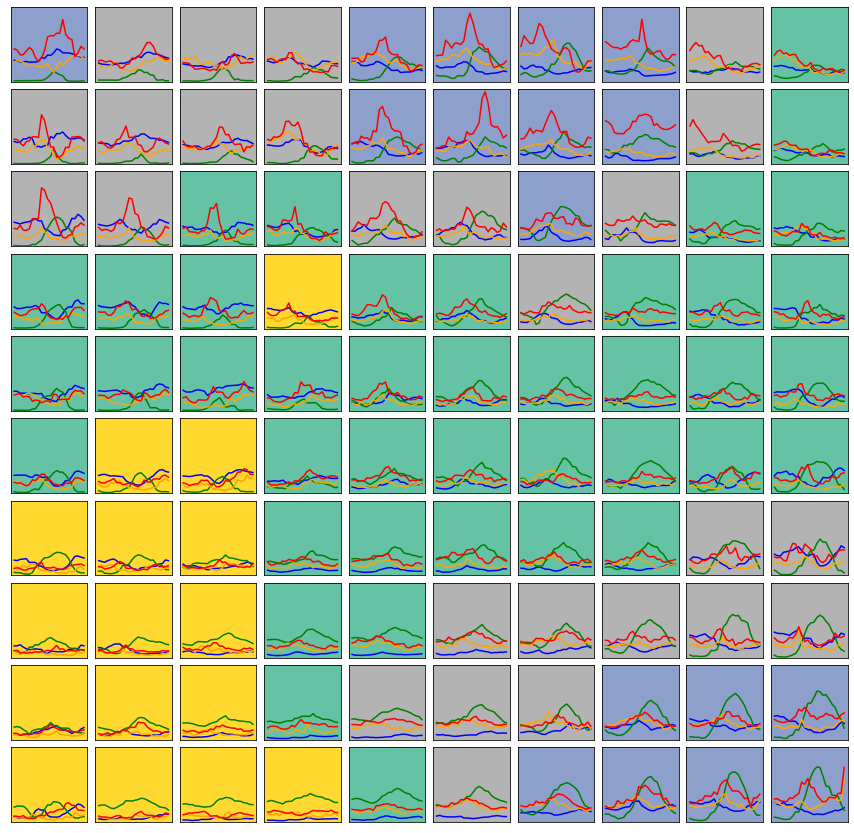

In [15]:
plt.figure(figsize=(15, 15))
norm = matplotlib.colors.Normalize(vmin=0, vmax=3, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Set2)
for i in range(10):
    maxylim= np.max(data_all)
    for j in range(10):
        ax = plt.subplot(10, 10, i*10 + 1+j)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_ylim((0,maxylim/5))
        plt.plot(np.array(weights)[0, i, j, :], color= 'blue')
        plt.plot(np.array(weights)[1, i, j, :], color= 'green')
        plt.plot(np.array(weights)[2, i, j, :], color= 'orange')
        plt.plot(np.array(weights)[3, i, j, :], color= 'red')
        ax.set_facecolor(mapper.to_rgba(KMeans_all.labels_[i*10 +j]))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Get winners of each neuron

### Calulate winners in each k-means cluster for sites

In [25]:
all_winners_by_site_df = pd.DataFrame(index = data_all_df.site.unique(), columns = range(4), data = 0)
for s in all_winners_by_site_df.index:
    data = data_all_df[data_all_df.site==s]
    data_s = np.swapaxes(np.array([np.stack(data["NO2"]), np.stack(data["O3"]), np.stack(data["PM25"]), np.stack(data["PM10"])]), 0, 1)
    for i in data_s:    
        x = som.winner(i)[0]
        y = som.winner(i)[1]      
        all_winners_by_site_df.loc[s,KMeans_all.labels_[x*10 +y]] += 1
        

In [26]:
all_winners_by_site_df

,0,1,2,3
037-0016,136,130,58,94
037-1002,176,76,82,112
037-1103,44,65,7,129
037-4002,139,1,92,35
059-0007,282,34,152,156
065-8001,144,205,61,155
065-8005,33,64,17,29
065-9001,185,93,86,203
071-1004,95,112,68,73


### Calulate the sites of winners in each neuron

In [22]:
winners_in_map = som.labels_map(data_all_new, data_all_df.site)